In [3]:
model_code = "02_02"
f_log_dir = "./"+model_code+"_log"
f_log_dir_train = "./"+model_code+"_log/training/"
f_log_dir_val = "./"+model_code+"_log/validate/"
f_chkpt_h5 = model_code+"_model"+".h5"
f_model_json = model_code+"_model_json"+".json"
f_model_weights = model_code+"_model_weights"+".h5"
f_infer_all = model_code+"_model_infer"+".txt"
f_model_png = model_code+"_model_image"+".png"

In [4]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

from pythainlp.tokenize import word_tokenize
from gensim.models import KeyedVectors
from itertools import cycle
from scipy import interp
from collections import Counter
from pprint import pprint

import dill as pickle
import numpy as np
import pandas as pd
import io
import sys
import graphviz
import pydot

#matplotlib
import matplotlib.font_manager as fm
import matplotlib.pyplot as plt

#keras
import keras.models
from keras.models import Sequential
from keras.layers import Dense, AveragePooling1D, Bidirectional
from keras.layers import LSTM, Convolution1D, Flatten, Dropout, Conv1D, RNN
from keras.layers import SpatialDropout1D, MaxPooling1D, TimeDistributed 
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence
from keras.callbacks import TensorBoard
from keras import losses
from keras.callbacks import ModelCheckpoint
from keras.preprocessing.sequence import pad_sequences
from keras.utils.vis_utils import plot_model
from keras.models import load_model

#sklearn
from sklearn import metrics
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_curve, auc
from sklearn import svm, datasets

#more

/usr/local/lib/python3.5/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [5]:
import tensorflow as tf

class TrainValTensorBoard(TensorBoard):
    def __init__(self, log_dir='./logs', **kwargs):
        # Make the original `TensorBoard` log to a subdirectory 'training'
        training_log_dir = f_log_dir_train #os.path.join(log_dir, 'training')
        super(TrainValTensorBoard, self).__init__(training_log_dir, **kwargs)

        # Log the validation metrics to a separate subdirectory
        self.val_log_dir = f_log_dir_val #os.path.join(log_dir, 'validation')

    def set_model(self, model):
        # Setup writer for validation metrics
        self.val_writer = tf.summary.FileWriter(self.val_log_dir)
        super(TrainValTensorBoard, self).set_model(model)

    def on_epoch_end(self, epoch, logs=None):
        # Pop the validation logs and handle them separately with
        # `self.val_writer`. Also rename the keys so that they can
        # be plotted on the same figure with the training metrics
        logs = logs or {}
        val_logs = {k.replace('val_', ''): v for k, v in logs.items() if k.startswith('val_')}
        for name, value in val_logs.items():
            summary = tf.Summary()
            summary_value = summary.value.add()
            summary_value.simple_value = value.item()
            summary_value.tag = name
            self.val_writer.add_summary(summary, epoch)
        self.val_writer.flush()

        # Pass the remaining logs to `TensorBoard.on_epoch_end`
        logs = {k: v for k, v in logs.items() if not k.startswith('val_')}
        super(TrainValTensorBoard, self).on_epoch_end(epoch, logs)

    def on_train_end(self, logs=None):
        super(TrainValTensorBoard, self).on_train_end(logs)
        self.val_writer.close()

In [6]:
#Thai2Vec Pre-trained Word Embedding
def sentence_vectorizer(ss,model,dim=300,use_mean=False):
    s = word_tokenize(ss)
    vec = np.zeros((1,dim))
    for word in s:
        if word in model.wv.index2word:
            vec+= model.wv.word_vec(word)
        else: pass
    if use_mean: vec /= len(s)
    return(vec)

#load into gensim
model = KeyedVectors.load_word2vec_format('thai2vec.vec',binary=False)

#create dataframe
thai2dict = {}
for word in model.index2word:
    thai2dict[word] = model[word]
thai2vec = pd.DataFrame.from_dict(thai2dict,orient='index')
#thai2vec.head()
print(len(thai2vec))

51358


In [7]:
#Our Train/Test/Validate Data
data_text = pd.read_csv('SentiFine_deepcut_raw_text_only_copy.txt', header=None, encoding="UTF-8", names = ["Text"])
data_label = pd.read_csv('SentiFine_raw_label_only.txt', header=None, encoding="UTF-8", names = ["Sentiment"])
data = pd.DataFrame({'text': data_text['Text'],
                    'sentiment': data_label['Sentiment']})
data.head()

sentiment                                               text
0   neutral  จิบชา ชิม เค้ก   กับ ร้าน ละเลียด   ธุรกิจ สอง...
1   neutral  ศัลยกรรม ตุ๊กตา   บลายล์   เปลี่ยน โฉม ใบ หน้า...
2   neutral  งาน THAIFEX - World   of   food   ASIA   ประกา...
3   neutral  เฟอร์นิเจอร์ ปลูก ต้น ไม้ นวัตกรรม ดีไซน์ ลด โ...
4   neutral  เผย   อุตไทยโตสวน กระแส   จี้ ปั้น แรงงาน ยอด ...

In [8]:
#Build up DataFrame for our Train/Test/Validate Data

#Decode Label from text to Int
temp_sentiment_int = []
for index in range(len(data)):
    if data['sentiment'][index] == 'neutral':
        temp_sentiment_int.append(0)
    elif data['sentiment'][index] == 'negative':
        temp_sentiment_int.append(1)
    elif data['sentiment'][index] == 'positive':
        temp_sentiment_int.append(2)        
    else:
        temp_sentiment_int.append("?")

#count the frequency of each word in a word list
reviews = data['text']
all_text = ' '.join(reviews)
words = all_text.split()
counts = Counter(words)
vocab = sorted(counts, key=counts.get, reverse=True)

#assign word to int and build a new list of data with int
vocab_to_int = {word: ii for ii, word in enumerate(vocab, 1)   }
reviews_ints = []
for each in reviews:
    reviews_ints.append([vocab_to_int[word] for word in each.split()])
    
review_lens = Counter([len(x) for x in reviews_ints])

non_zero_idx = [ii for ii, review in enumerate(reviews_ints) if len(review) != 0]

reviews_ints = [reviews_ints[ii] for ii in non_zero_idx]

data = pd.DataFrame({'Text': data['text'],
                    'Text_int': reviews_ints,
                    'Sentiment': data['sentiment'],
                    'Sentiment_int': temp_sentiment_int
                    })

data.head()

Sentiment  Sentiment_int                                               Text  \
0   neutral              0  จิบชา ชิม เค้ก   กับ ร้าน ละเลียด   ธุรกิจ สอง...   
1   neutral              0  ศัลยกรรม ตุ๊กตา   บลายล์   เปลี่ยน โฉม ใบ หน้า...   
2   neutral              0  งาน THAIFEX - World   of   food   ASIA   ประกา...   
3   neutral              0  เฟอร์นิเจอร์ ปลูก ต้น ไม้ นวัตกรรม ดีไซน์ ลด โ...   
4   neutral              0  เผย   อุตไทยโตสวน กระแส   จี้ ปั้น แรงงาน ยอด ...   

                                            Text_int  
0  [3986, 3563, 1288, 217, 102, 3673, 140, 715, 6...  
1  [5891, 3466, 6568, 614, 1000, 616, 215, 1590, ...  
2  [130, 4661, 5, 2571, 3627, 4500, 2768, 206, 57...  
3  [2049, 1439, 375, 2014, 1454, 4420, 33, 101, 381]  
4  [99, 4594, 550, 661, 850, 519, 131, 1590, 2890...

In [9]:
#Define some static parameters of model

# Embedding
max_features = 20000
maxlen = 100
embedding_size = 128

# Convolution
kernel_size = 5
filters = 64
pool_size = 4

# LSTM
lstm_output_size = 70

# Training
batch_size = 30
epochs = 30

In [10]:
#Build Up X & Y for the Sequential Model

X = data['Text_int']
X = pad_sequences(X, maxlen = maxlen)

Y = pd.get_dummies(data['Sentiment'], columns=['negative','neural','positive']).values

#Split data to 2 parts: 1. XX&YY = train&test set  2. X_val&Y_val = validate set
XX, X_val, YY, Y_val = train_test_split(X,Y, test_size = 0.20, random_state = 42)

In [11]:
#Overall Data Summary 
print('No. of negative, neutral, positive in dataset:')
print(data[ data['Sentiment'] == 'negative'].size, data[ data['Sentiment'] == 'neutral'].size, data[ data['Sentiment'] == 'positive'].size)

print('Shape of XX&YY train&test data set:')
print(XX.shape,YY.shape)

print('Shape of X&Y validate data set:')
print(X_val.shape,Y_val.shape)

No. of negative, neutral, positive in dataset:
15244 4768 17396
Shape of XX&YY train&test data set:
(7481, 100) (7481, 3)
Shape of X&Y validate data set:
(1871, 100) (1871, 3)


In [12]:
#Build model

model = Sequential()
model.add(Embedding(max_features, embedding_size, input_length=maxlen))
# model.add(Dropout(0.25))
# model.add(Conv1D(filters, kernel_size, padding='valid', activation='relu', strides=1))
# model.add(MaxPooling1D(pool_size=pool_size))
# model.add(LSTM(lstm_output_size))
# model.add(Dense(3,activation='softmax'))
# model.compile(loss = 'categorical_crossentropy', optimizer='adam',metrics = ['accuracy'])
model.add(LSTM(128, return_sequences=True))
model.add(LSTM(64, return_sequences=True))
model.add(LSTM(32, return_sequences=True))
model.add(LSTM(16, return_sequences=True))
#model.add(TimeDistributed(Dense(1)))
model.add(Dropout(0.5))
model.add(Flatten())
model.add(Dense(3, activation='softmax'))
model.compile(loss = 'categorical_crossentropy', optimizer='adam',metrics = ['accuracy'])

print(model.summary())
#plot_model(model, to_file=f_model_png)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 100, 128)          2560000   
_________________________________________________________________
lstm_1 (LSTM)                (None, 100, 128)          131584    
_________________________________________________________________
lstm_2 (LSTM)                (None, 100, 64)           49408     
_________________________________________________________________
lstm_3 (LSTM)                (None, 100, 32)           12416     
_________________________________________________________________
lstm_4 (LSTM)                (None, 100, 16)           3136      
_________________________________________________________________
dropout_1 (Dropout)          (None, 100, 16)           0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 1600)              0         
__________

In [13]:
import time 
time.sleep(8000)

In [14]:
#Start training
tensorBoardCallback = TensorBoard(log_dir=f_log_dir, write_graph=True)
checkpointer = ModelCheckpoint(filepath=f_chkpt_h5, verbose=1, save_best_only=True)

#No. of K-fold
k = 5
l = int(len(XX) / k)
#print(l)
mse_total, mae_total = 0, 0
for i in range(k):
    X_test = XX[i*l:(i+1)*l]
    Y_test = YY[i*l:(i+1)*l]

    X_train = np.concatenate([XX[:i*l], XX[(i+1)*l:]]);
    Y_train = np.concatenate([YY[:i*l], YY[(i+1)*l:]]);
    
    #print(X_train.shape, Y_train.shape)
    #print(X_test.shape, Y_test.shape)
    
    #model.fit(train_x, train_y, epochs=15)
    model.fit(X_train, Y_train, 
              batch_size=batch_size, 
              epochs=epochs,
              shuffle=True, 
              callbacks=[checkpointer,tensorBoardCallback],
              validation_data=(X_test, Y_test))

    #predictions = model.predict(test_x)
    #scores = model.evaluate(X_test, Y_test, verbose=0)
    #print("Accuracy: %.2f%%" % (scores[1]*100))
    mse, mae = model.evaluate(X_val, Y_val, verbose=1)
    mse_total += mse
    mae_total += mae

mse_avg = mse_total / k
mae_avg = mae_total / k
print('MSE_AVG: ' + str(mse_avg) + ', MAE_AVG: ' + str(mae_avg))
print("Accuracy: %.2f%%" % (mae_avg*100))

Train on 5985 samples, validate on 1496 samples
Epoch 1/30
5985/5985 [==============================] - 52s 9ms/step - loss: 0.9399 - acc: 0.4797 - val_loss: 0.8096 - val_acc: 0.5795

Epoch 00001: val_loss improved from inf to 0.80964, saving model to 02_02_model.h5
Epoch 2/30
5985/5985 [==============================] - 51s 9ms/step - loss: 0.5824 - acc: 0.7683 - val_loss: 0.5039 - val_acc: 0.8235

Epoch 00002: val_loss improved from 0.80964 to 0.50395, saving model to 02_02_model.h5
Epoch 3/30
5985/5985 [==============================] - 51s 9ms/step - loss: 0.3300 - acc: 0.8922 - val_loss: 0.4923 - val_acc: 0.8229

Epoch 00003: val_loss improved from 0.50395 to 0.49229, saving model to 02_02_model.h5
Epoch 4/30
5985/5985 [==============================] - 51s 9ms/step - loss: 0.2158 - acc: 0.9362 - val_loss: 0.5199 - val_acc: 0.8229

Epoch 00004: val_loss did not improve from 0.49229
Epoch 5/30
5985/5985 [==============================] - 51s 9ms/step - loss: 0.1603 - acc: 0.9536 - 

5985/5985 [==============================] - 51s 9ms/step - loss: 0.0362 - acc: 0.9851 - val_loss: 0.0903 - val_acc: 0.9726

Epoch 00013: val_loss did not improve from 0.04287
Epoch 14/30
5985/5985 [==============================] - 51s 9ms/step - loss: 0.0233 - acc: 0.9898 - val_loss: 0.1101 - val_acc: 0.9706

Epoch 00014: val_loss did not improve from 0.04287
Epoch 15/30
5985/5985 [==============================] - 51s 9ms/step - loss: 0.0333 - acc: 0.9865 - val_loss: 0.1088 - val_acc: 0.9679

Epoch 00015: val_loss did not improve from 0.04287
Epoch 16/30
5985/5985 [==============================] - 51s 9ms/step - loss: 0.0337 - acc: 0.9878 - val_loss: 0.1012 - val_acc: 0.9699

Epoch 00016: val_loss did not improve from 0.04287
Epoch 17/30
5985/5985 [==============================] - 51s 9ms/step - loss: 0.0240 - acc: 0.9901 - val_loss: 0.1018 - val_acc: 0.9679

Epoch 00017: val_loss did not improve from 0.04287
Epoch 18/30
5985/5985 [==============================] - 51s 9ms/step - 

5985/5985 [==============================] - 51s 9ms/step - loss: 0.0150 - acc: 0.9921 - val_loss: 0.1019 - val_acc: 0.9759

Epoch 00026: val_loss did not improve from 0.02434
Epoch 27/30
5985/5985 [==============================] - 51s 9ms/step - loss: 0.0154 - acc: 0.9923 - val_loss: 0.1005 - val_acc: 0.9773

Epoch 00027: val_loss did not improve from 0.02434
Epoch 28/30
5985/5985 [==============================] - 51s 9ms/step - loss: 0.0138 - acc: 0.9926 - val_loss: 0.0965 - val_acc: 0.9779

Epoch 00028: val_loss did not improve from 0.02434
Epoch 29/30
5985/5985 [==============================] - 51s 9ms/step - loss: 0.0148 - acc: 0.9920 - val_loss: 0.1063 - val_acc: 0.9786

Epoch 00029: val_loss did not improve from 0.02434
Epoch 30/30
5985/5985 [==============================] - 51s 9ms/step - loss: 0.0157 - acc: 0.9918 - val_loss: 0.1663 - val_acc: 0.9672

Epoch 00030: val_loss did not improve from 0.02434
1871/1871 [==============================] - 3s 2ms/step
Train on 5985 s

5985/5985 [==============================] - 51s 9ms/step - loss: 0.0157 - acc: 0.9920 - val_loss: 0.0304 - val_acc: 0.9873

Epoch 00008: val_loss did not improve from 0.02163
Epoch 9/30
5985/5985 [==============================] - 51s 9ms/step - loss: 0.0161 - acc: 0.9911 - val_loss: 0.0304 - val_acc: 0.9886

Epoch 00009: val_loss did not improve from 0.02163
Epoch 10/30
5985/5985 [==============================] - 51s 9ms/step - loss: 0.0147 - acc: 0.9926 - val_loss: 0.0304 - val_acc: 0.9893

Epoch 00010: val_loss did not improve from 0.02163
Epoch 11/30
5985/5985 [==============================] - 51s 9ms/step - loss: 0.0160 - acc: 0.9925 - val_loss: 0.0318 - val_acc: 0.9873

Epoch 00011: val_loss did not improve from 0.02163
Epoch 12/30
5985/5985 [==============================] - 51s 9ms/step - loss: 0.0156 - acc: 0.9921 - val_loss: 0.0320 - val_acc: 0.9880

Epoch 00012: val_loss did not improve from 0.02163
Epoch 13/30
5985/5985 [==============================] - 51s 9ms/step - l

In [15]:
#Evaluation

y_true = []

yhat_class = model.predict_classes(X_val)
yhat = model.predict(X_val, verbose = 2, batch_size = batch_size)

for each in range(len(Y_val)):
    if (Y_val[each][0] == 1) & (Y_val[each][1] == 0) & (Y_val[each][2] == 0) : #negative
        y_true.append(0)
    elif (Y_val[each][0] == 0) & (Y_val[each][1] == 1) & (Y_val[each][2] == 0) : #neutral
        y_true.append(1)
    elif (Y_val[each][0] == 0) & (Y_val[each][1] == 0) & (Y_val[each][2] == 1) : #positive
        y_true.append(2)
    else:
        y_true.append(-1)

print(metrics.classification_report(y_true, yhat_class ,target_names = ["negative", "neutral","positive"]))

             precision    recall  f1-score   support

   negative       0.84      0.84      0.84       735
    neutral       0.77      0.72      0.75       260
   positive       0.85      0.86      0.86       876

avg / total       0.83      0.83      0.83      1871



In [16]:
#Confusion Matrix

y_score = model.predict(X_val)

import itertools

score = ['negative', 'neutral','positive']

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Greys):
#     plt.imshow(cm, interpolation='nearest', cmap=cmap)
#     plt.title(title)
#     plt.colorbar()
#     tick_marks = np.arange(len(set(score)))
#     plt.xticks(tick_marks, score, rotation=45)
#     plt.yticks(tick_marks, score)
#     plt.tight_layout()
#     plt.ylabel('True label')
#     plt.xlabel('Predicted label')
    
# Compute confusion matrix
# cm = confusion_matrix(Y_val[:,1], np.round(yhat[:,1]))
# np.set_printoptions(precision=3)
# plt.figure()
# plot_confusion_matrix(cm)    

# cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
# plt.figure()
# plot_confusion_matrix(cm_normalized, title='Normalized confusion matrix')

# plt.show()

yFit_class = np.argmax(y_score, axis=1)
yVal_class = np.argmax(Y_val, axis=1)

plot_confusion_matrix(confusion_matrix(yVal_class, yFit_class, labels=[0,1,2]), 
                      classes=['negative','neutral','positive'], 
                      normalize=True,
                      title='Normalized confusion matrix')


Normalized confusion matrix
[[0.83809524 0.03129252 0.13061224]
 [0.12307692 0.72307692 0.15384615]
 [0.09817352 0.03767123 0.86415525]]


In [17]:
#load the best model
best_model = load_model(f_chkpt_h5)

# serialize model to JSON
model_json = best_model.to_json()
with open(f_model_json, "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
best_model.save_weights(f_model_weights)

1871/1871 [==============================] - 3s 2ms/step


| Labels\Metrics   |   Precision |   Recall |   F-Score |   Support |
|:-----------------|------------:|---------:|----------:|----------:|
| negative         |    0.825748 | 0.863946 |  0.844415 |       735 |
| neutral          |    0.710037 | 0.734615 |  0.722117 |       260 |
| positive         |    0.870348 | 0.827626 |  0.848449 |       876 |


Precision: 0.830550
Recall: 0.828968
F1: 0.829309
Accuracy: 0.828968


Normalized confusion matrix
[[0.86394558 0.03809524 0.09795918]
 [0.12692308 0.73461538 0.13846154]
 [0.1152968  0.05707763 0.82762557]]




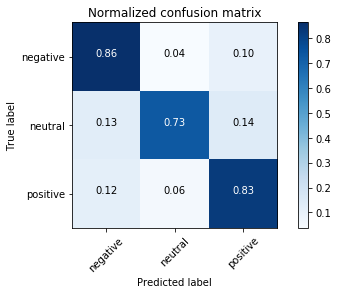

In [18]:
#sklearn
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_curve, auc, roc_auc_score, precision_score, recall_score, f1_score, accuracy_score
from sklearn.metrics import precision_recall_fscore_support as score

#more
from IPython.display import HTML, display
import tabulate
import itertools

yFit = best_model.predict(X_val, batch_size=batch_size, verbose=1)
yFit_class = np.argmax(yFit, axis=1)
yVal_class = np.argmax(Y_val, axis=1)

precision, recall, fscore, support = score(yVal_class, yFit_class, 
                                           average=None,labels = [0, 1, 2])

table = [['negative',precision[0],recall[0],fscore[0],support[0]],
['neutral',precision[1],recall[1],fscore[1],support[1]],
['positive',precision[2],recall[2],fscore[2],support[2]]]

#display(HTML(tabulate.tabulate(table, tablefmt='html', headers=['Labels\Metrics','Precision', 'Recall', 'F-Score', 'Support'])))
print("\n")
print(tabulate.tabulate(table, tablefmt='pipe', headers=['Labels\Metrics','Precision', 'Recall', 'F-Score', 'Support']))

print("\n")
w_precision = format(precision_score(yVal_class, yFit_class, average='weighted'),'.6f')
w_recall = format(recall_score(yVal_class, yFit_class, average='weighted'),'.6f')
w_fscore = format(f1_score(yVal_class, yFit_class, average='weighted'),'.6f')
w_accuracy = format(accuracy_score(yVal_class, yFit_class, normalize=True),'.6f')
#w_roc = format(roc_auc_score(yVal_class, yFit_class, average='weighted'),'.6f')
print("Precision: %s" % w_precision)
print("Recall: %s" % w_recall)
print("F1: %s" % w_fscore)
print("Accuracy: %s" % w_accuracy)

print("\n")
#plt.figure()
plot_confusion_matrix(confusion_matrix(yVal_class, yFit_class, labels=[0,1,2]), 
                      classes=['negative','neutral','positive'], 
                      normalize=True,
                      title='Normalized confusion matrix')


print("\n")
display(HTML(tabulate.tabulate(table, tablefmt='latex', headers=['Labels\Metrics','Precision', 'Recall', 'F-Score', 'Support'])))


In [ ]:
from IPython.core.display import HTML
HTML("<script>Jupyter.notebook.kernel.restart()</script>")